# An example using Feature weighted ECM clustering


In [1]:
## Importing
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import matplotlib.pyplot as plt
from evclust.ecm import ecm
from evclust.fwecm import fwecm
from evclust.utils import ev_summary, ev_plot, ev_pcaplot
import pandas as pd
from sklearn.metrics import adjusted_rand_score, silhouette_score
import seaborn as sns
from evclust.datasets import load_2d_dataset



In [2]:
def get_ensembles(table):
    result = []
    for row in table:
        row_str = 'Cl_' + '_'.join([str(i + 1) if elem == 1 else str(int(elem)) for i, elem in enumerate(row) if elem != 0])
        result.append(row_str)

    result[0] = 'Cl_atypique'
    result[-1] = 'Cl_incertains'

    cleaned_result = [''.join(ch for i, ch in enumerate(row_str) if ch != '_' or (i > 0 and row_str[i-1] != '_')) for row_str in result]

    return cleaned_result

def ev_plot_2D(data, x, normalize=False, splite=False, cex=8, cex_protos=5):
    mas = pd.DataFrame(x["mass"])
    c = len(np.unique(x['y_pl']))
    cols = get_ensembles(x['F'])
    mas.columns = cols
    mas["Cluster"] = mas.apply(lambda row: row.idxmax(), axis=1)

    # pca = PCA(n_components=2)
    # pca_result = pca.fit_transform(data)

    # variance_percent = np.round(pca.explained_variance_ratio_ * 100, 1)

    ind_coord = pd.DataFrame(data, columns=["Dim.1", "Dim.2"])
    ind_coord["Cluster"] = pd.Categorical(mas["Cluster"])
    mean_coords = ind_coord.groupby('Cluster').mean()

    pcolor = sns.color_palette("Dark2", n_colors=len(ind_coord["Cluster"].unique()))
    plt.figure(figsize=(8, 6))

    if splite:
        sns.relplot(data=ind_coord, x="Dim.1", y="Dim.2", hue="Cluster", col="Cluster",
                    style="Cluster", palette=pcolor, s=cex, col_wrap=int((c ** 2) / 2))
    else:
        sns.scatterplot(data=ind_coord, x="Dim.1", y="Dim.2", hue="Cluster", palette=pcolor,
                        style="Cluster", s=cex)
        sns.scatterplot(data=mean_coords, x="Dim.1", y="Dim.2", s=(cex + 25), hue="Cluster",
                        palette=pcolor, style="Cluster", legend=False)

    sns.despine()
    legend = plt.legend(title="Cluster", loc='upper left', markerscale=0.3)
    plt.setp(legend.get_title(), fontsize=7)
    plt.setp(legend.get_texts(), fontsize=7)
    plt.tick_params(axis='both', labelsize=7)
    plt.axis('equal')
    plt.show()
    
def credal_partition_contour_lines(model, X, marker_list):
    mass = model['mass']
    clusters = np.argmax(mass, axis=1)
    contour_list = np.array([])
    datapoint_list = []
    for i in range(mass.shape[1]):
        indices = np.where(clusters == i)
        datapoints = X[indices]
        if len(datapoints) > 3:
            datapoint_list.append(datapoints)
            memberships = mass[indices, i].ravel()
            contour = plt.tricontourf(datapoints[:, 0], datapoints[:, 1], memberships, cmap='viridis', alpha=0.6)
            contour_list = np.append(contour_list, contour)
    
    plt.colorbar(contour_list[0], label='Mass value')
    
    for i in range(len(marker_list)):
        datapoints = datapoint_list[i]
        plt.scatter(datapoints[:, 0], datapoints[:, 1], marker=marker_list[i], s=20)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Credal partition')
    plt.xlim(-2, 7)
    plt.ylim(1, 9)
    plt.show()

In [3]:
# Non-specificity values
def calculate_non_specificity(cluster_model):
    m = cluster_model['mass']
    F = cluster_model['F']
    c = F.shape[1]
    card = np.sum(F[1:F.shape[0], :], axis=1)

    log_card = np.log2(card)
    tmp = np.tile(log_card.transpose(), (m.shape[0], 1))
    m_log_card = m[:, :-1] * tmp

    mvide = m[:, -1][:, np.newaxis]
    tmp2 = mvide * np.log2(c)
    tmp3 = np.tile(tmp2, (1, m.shape[1] - 1))

    non_specificity = m_log_card + tmp3
    object_non_specificity = np.sum(non_specificity, axis=1)

    print(f"Maximum Non-specificity value: {max(object_non_specificity)}")
    print(f"Minimum Non-specificity value: {min(object_non_specificity)}")
    print(f"Average Non-specificity value: {np.mean(object_non_specificity)}")

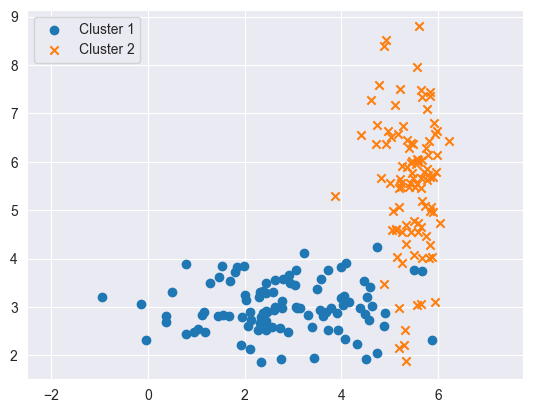

In [4]:
## Generating data set
# Number of samples in the cluster
# num_samples = 100
# 
# # Mean and covariance for the cluster
# mean = [3, 3]
# covariance1 = [[2, 0],
#                [0, 0.2]]  # Wider along x-axis, narrower along y-axis
# cluster1 = np.random.multivariate_normal(mean, covariance1, num_samples)
# cluster1 = np.c_[cluster1, np.zeros((cluster1.shape[0], 1))]
# 
# mean = [5.5, 5.5]
# covariance2 = [[0.2, 0],
#                [0, 2]]  # Wider along y-axis, narrower along x-axis
# cluster2 = np.random.multivariate_normal(mean, covariance2, num_samples)
# cluster2 = np.c_[cluster2, np.ones((cluster2.shape[0], 1))]

# dataset = np.vstack([cluster1, cluster2])
dataset = load_2d_dataset().values
last_column = dataset[:, -1]
cluster1 = dataset[last_column == 0]
cluster2 = dataset[last_column == 1]

df = pd.DataFrame(data=dataset[:, :-1], columns=['X-axis', 'Y-axis'])
plt.scatter(cluster1[:, 0], cluster1[:, 1], marker='o', label='Cluster 1')
plt.scatter(cluster2[:, 0], cluster2[:, 1], marker='x', label='Cluster 2')
# plt.xlabel('X-axis')
# plt.ylabel('Y-axis')
# plt.title('2D Dataset with two clusters - Wide x-Axis, Narrow y-Axis')
plt.legend()
plt.axis('equal')
plt.show()

In [5]:
# Traditional ECM clustering
model = ecm(x=df, c=2, beta=2, alpha=1, delta=100, ntrials=10)

[1, 237.56153773765695]
[2, 232.0884607729455]
[3, 231.3626647556563]
[4, 231.19684471276753]
[5, 231.14129113738323]
[6, 231.12058398756292]
[7, 231.1127070479001]
[8, 231.1097014599054]
[9, 231.10855478394166]
[10, 231.10811771780652]
[  0.         231.10811772 231.10811772]
[1, 237.56153773765692]
[2, 232.0884607729455]
[3, 231.3626647556563]
[4, 231.19684471276753]
[5, 231.14129113738323]
[6, 231.12058398756295]
[7, 231.1127070479001]
[8, 231.10970145990544]
[9, 231.10855478394163]
[10, 231.10811771780652]
[  1.         231.10811772 231.10811772]
[1, 237.56153773765695]
[2, 232.0884607729455]
[3, 231.3626647556563]
[4, 231.19684471276753]
[5, 231.14129113738323]
[6, 231.12058398756292]
[7, 231.1127070479001]
[8, 231.1097014599054]
[9, 231.10855478394166]
[10, 231.10811771780652]
[  2.         231.10811772 231.10811772]
[1, 237.56153773765692]
[2, 232.0884607729455]
[3, 231.3626647556563]
[4, 231.19684471276753]
[5, 231.14129113738323]
[6, 231.12058398756295]
[7, 231.1127070479001]


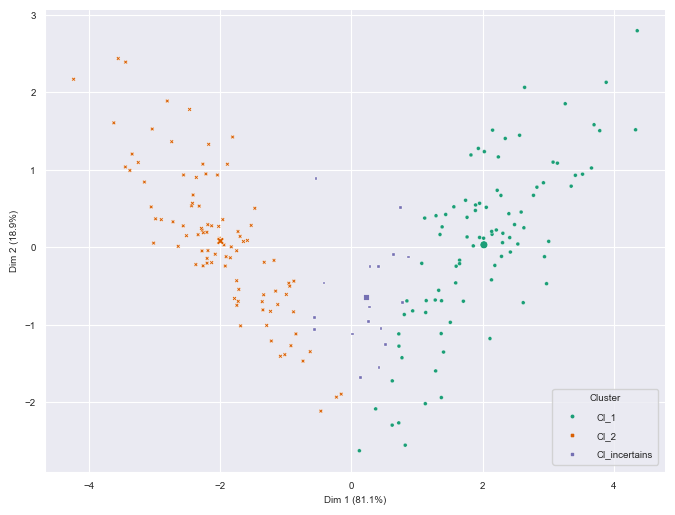

Adjusted Rand Index (ARI): 0.8456245542938297
Silhouette Index (SI): 0.5717648825599412
Maximum Non-specificity value: 2.6823721060034997
Minimum Non-specificity value: 0.0017485441322600485
Average Non-specificity value: 0.9028128163475663


In [6]:

# ev_plot(model, X=df)
ev_pcaplot(data=df, x=model, normalize=False)

true_labels = dataset[:, -1]
Y_betP = model['betp']
predicted_labels = np.argmax(Y_betP, axis=1)

# Compute the Adjusted Rand Index (ARI)
ari = adjusted_rand_score(true_labels, predicted_labels)
print(f"Adjusted Rand Index (ARI): {ari}")

# Compute the Silhouette Index (SI)
si = silhouette_score(dataset[:, :-1], predicted_labels)
print(f"Silhouette Index (SI): {si}")

# Calculate Non-specificity
calculate_non_specificity(model)

# (Traditional ECM) Hard partition in 2-D without PCA

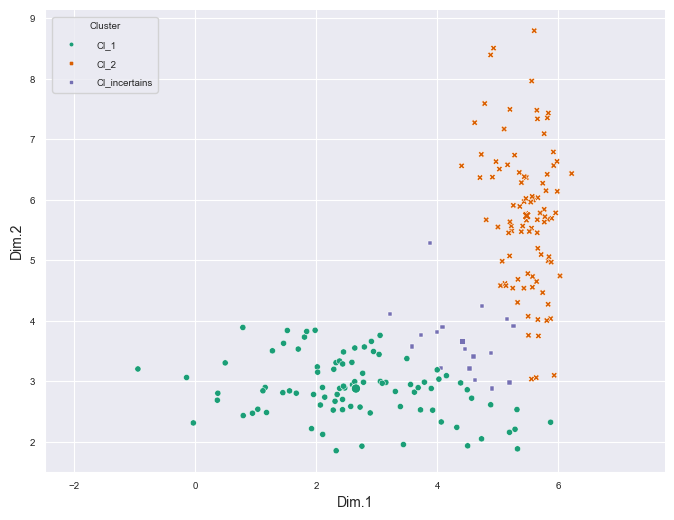

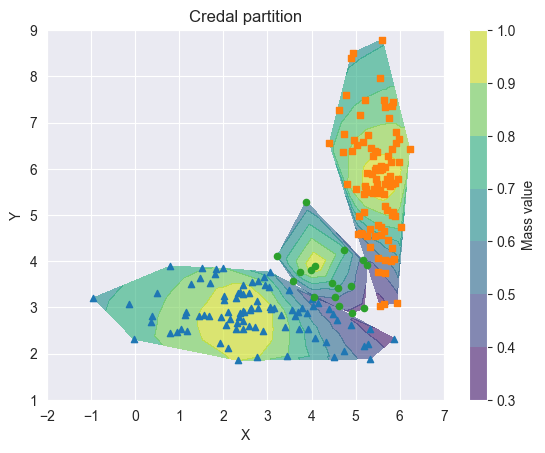

In [7]:
# Hard partition in 2-D without pCA
ev_plot_2D(data=dataset[:, :-1], x=model, normalize=False, cex=20)

marker_list = ['^', 's', 'o']
credal_partition_contour_lines(model, df.values, marker_list)

In [17]:
# Feature weighted ECM clustering
c = 2
d = df.shape[1]
W = np.ones((c, d)) * (1/d)
model = fwecm(x=df, c=c, W=W, beta=2, alpha=1, delta=100, ntrials=10)


Initial weight matrix: 
 [[0.5 0.5]
 [0.5 0.5]]
[1, 59.415019210019196]
[2, 28.253802668635732]
[3, 25.02094712331854]
[4, 24.709092231410594]
[5, 24.588595008091616]
[6, 24.52545119811267]
[7, 24.48406599682104]
[8, 24.452029875617107]
[9, 24.423589823955826]
[10, 24.395342400252673]
[11, 24.364797952844825]
[12, 24.329600066559998]
[13, 24.287207182579934]
[14, 24.234848645800025]
[15, 24.16990232885464]
[16, 24.090923958175452]
[17, 23.999364507344183]
[18, 23.900821090068643]
[19, 23.804484302362624]
[20, 23.71948089169318]
[21, 23.65115473154633]
[22, 23.60031182535807]
[23, 23.564737281852953]
[24, 23.541051194524826]
[25, 23.525930888611793]
[26, 23.51660120938587]
[27, 23.511007704664213]
[28, 23.507725340885894]
[29, 23.505834494015737]
[30, 23.50475772749878]
[31, 23.504152039571576]
[ 0.         23.50415204 23.50415204]
Initial weight matrix: 
 [[0.5 0.5]
 [0.5 0.5]]
[1, 59.415019210019196]
[2, 28.253802668635732]
[3, 25.02094712331854]
[4, 24.709092231410594]
[5, 24.5885950

Weights: [[0.95529219 0.04470781]
 [0.00953084 0.99046916]]
Centers: [[ 5.44897418  4.40455718]
 [-0.15331218  2.8330761 ]]


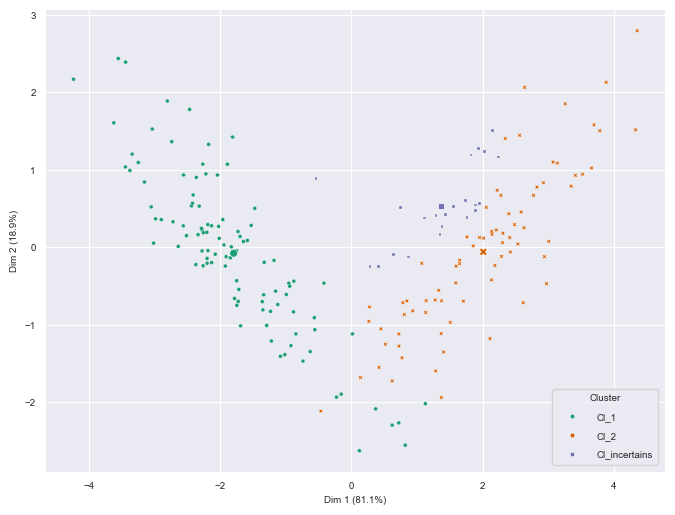

Adjusted Rand Index (ARI): 0.8642182939572497 - J value: 23.504152039571576
Silhouette Index (SI): 0.5486487090235471
Maximum Non-specificity value: 2.9885975239225764
Minimum Non-specificity value: 0.0002915770817141692
Average Non-specificity value: 0.7498046149581422


In [18]:
print(f"Weights: {model['W']}")
print(f"Centers: {model['g']}")

# ev_plot(model, X=df)
ev_pcaplot(data=df, x=model, normalize=False)

# Compute the Adjusted Rand Index (ARI)
true_labels = dataset[:, -1]
Y_betP = model['betp']
predicted_labels = np.argmax(Y_betP, axis=1)

ari = adjusted_rand_score(true_labels, predicted_labels)
print(f"Adjusted Rand Index (ARI): {ari} - J value: {model['crit']}")

# Compute the Silhouette Index (SI)
si = silhouette_score(dataset[:, :-1], predicted_labels)
print(f"Silhouette Index (SI): {si}")

# Calculate Non-specificity
calculate_non_specificity(model)

# (Weighted ECM) Hard partition in 2-D without PCA

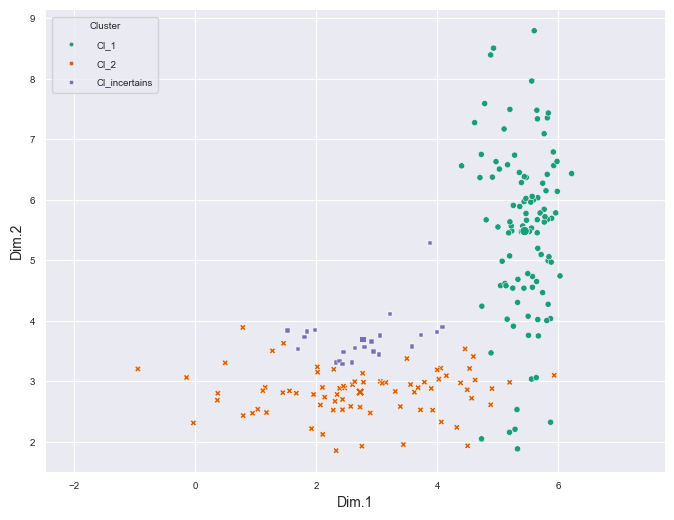

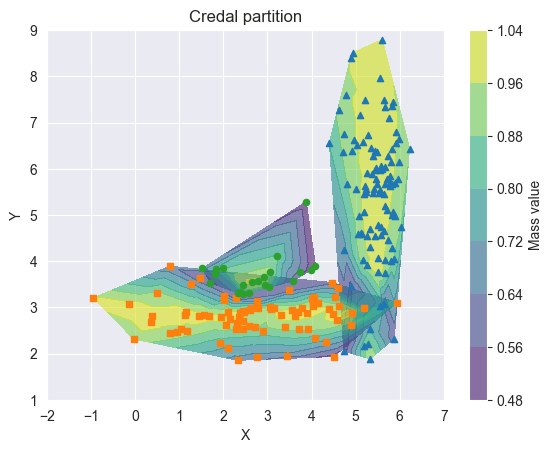

In [19]:
ev_plot_2D(data=dataset[:, :-1], x=model, normalize=False, cex=20)

marker_list = ['^', 's', 'o']
credal_partition_contour_lines(model, df.values, marker_list)